In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy.optimize import minimize
from tqdm import tqdm
from collections import defaultdict

In [3]:
task_data = pd.read_csv('PD_data_choice.csv')

### BRL

- Model fitting

In [5]:
def pd_brl_loglikelihood(sub_data, beta_param, bias, gamma_pos, gamma_neg):
    """
    Bayesian Reinforcement Learning log-likelihood function for Iterative Prisoner's Dilemma
    
    Parameters:
    sub_data: DataFrame with subject data (80 rounds per subject)
    beta_param: softmax temperature parameter for the player
    bias: bias parameter
    gamma_pos: learning rate for cooperative outcomes
    gamma_neg: learning rate for defective outcomes
    
    Returns:
    BayesLL: negative log-likelihood
    """
    
    # Read trial parameters
    trial = sub_data['round_number'].values
    p1_choice = sub_data['p1_choice'].values
    p2_choice = sub_data['p2_choice'].values
    
    # Number of trials
    num_trials = len(trial)
    
    # Initialize priors for each 'player type': uniform probability
    a_init = 1.01
    b_init = 1.01
    
    # Set alpha and beta for each 'player type'
    a = a_init
    b = b_init
    
    # Store mean beta distribution and log likelihood
    mew = np.zeros(num_trials)
    loglike = np.zeros(num_trials)
    
    # Loop over trials
    for t in range(num_trials):
        # Beta distribution to compute chris's probability of cooperating
        mew[t] = a / (a + b)
        
        # Human choice probability
        if p1_choice[t] == 1:  # probability of cooperating
            choice_prob = np.exp(beta_param * mew[t]) / (np.exp(beta_param * mew[t]) + np.exp(beta_param * bias))
        else:  # probability of defecting
            choice_prob = 1 - np.exp(beta_param * mew[t]) / (np.exp(beta_param * mew[t]) + np.exp(beta_param * bias))
        
        # Update strategies based on partner's action
        if p2_choice[t] == 1:
            a += 1  # cooperate
        else:
            b += 1  # defect
        
        a_prev = a
        b_prev = b
        
        # Implement learning rate
        a = a_prev * gamma_pos  # cooperate LR
        b = b_prev * gamma_neg  # defect LR
        
        # Get trial log-likelihood
        loglike[t] = np.log(choice_prob)
    
    # Return negative sum of log-likelihood
    bayes_ll = -np.sum(loglike)
    return bayes_ll

In [10]:
bounds = [(1, 20), (0.1, 1), (0.1, 1), (0.1, 1)]
    
# Initialize results dictionary
params = {
    'subjNum': [],
    'subjBetaParam': [],
    'subjBias': [],
    'subjGammaPos': [],
    'subjGammaNeg': [],
    'subjBayesLL': []
}

# Subject list
sub_list = task_data['ppt_number'].unique()

for sub_num in tqdm(sub_list, desc="Fitting subjects", unit="subject"):
    
    # Get subject data
    sub_data = task_data[task_data['ppt_number'] == sub_num].copy()
    
    # Remove NaNs
    sub_data = sub_data.dropna()
    
    # Set number of iterations/starting points
    n_iter = 20
    
    if not sub_data.empty:  # if we have data for subject to model
        
        results = []
        likelihoods = []
        
        for iteration in range(n_iter):
            # Random initial values
            np.random.seed()
            init_vals = [
                np.random.rand() * 20,                    # beta_param: 0-20
                (np.random.rand() + 0.1) * 0.9,         # bias: 0.1-1
                (np.random.rand() + 0.1) * 0.9,         # gamma_pos: 0.1-1
                (np.random.rand() + 0.1) * 0.9          # gamma_neg: 0.1-1
            ]
            
            # Optimize parameters
            def objective(x):
                return pd_brl_loglikelihood(sub_data, x[0], x[1], x[2], x[3])
            
            try:
                result = minimize(objective, init_vals, bounds=bounds, method='L-BFGS-B')
                results.append(result.x)
                likelihoods.append(result.fun)
            except:
                # If optimization fails, skip this iteration
                continue
        
        if likelihoods:  # If we have valid results
            # Find minimum likelihood
            min_bayes_ll = min(likelihoods)
            best_idx = likelihoods.index(min_bayes_ll)
            
            # Save best fitting parameters
            best_params = results[best_idx]
            beta = best_params[0]
            bias = best_params[1]
            gamma_pos = best_params[2]
            gamma_neg = best_params[3]
            
            # Store results
            params['subjNum'].append(sub_num)
            params['subjBetaParam'].append(beta)
            params['subjBias'].append(bias)
            params['subjGammaPos'].append(gamma_pos)
            params['subjGammaNeg'].append(gamma_neg)
            params['subjBayesLL'].append(min_bayes_ll)
            
            # Save intermediate results
            with open('m1_PD_BRL.pkl', 'wb') as f:
                pickle.dump(params, f)

# Compute AIC
num_params = len(bounds)
params['subjAIC'] = [-2 * ll - 2 * num_params for ll in params['subjBayesLL']]

# Create results DataFrame
results_df = pd.DataFrame({
    'sub_num': params['subjNum'],
    'betaParam': params['subjBetaParam'],
    'bias': params['subjBias'],
    'gammaPos': params['subjGammaPos'],
    'gammaNeg': params['subjGammaNeg'],
    'BayesLL': params['subjBayesLL'],
    'AIC': params['subjAIC']
})

# Save to Excel file
results_df.to_csv('PD_BRL_fitting_results.csv', index=False)

print("Model fitting completed!")

Fitting subjects: 100%|██████████| 142/142 [01:50<00:00,  1.28subject/s]

Model fitting completed!


- Results analysis

In [11]:
results_df.head()

,sub_num,betaParam,bias,gammaPos,gammaNeg,BayesLL,AIC
0,1,9.343734,0.478638,0.645417,0.619850,28.328629,-64.657258
1,3,20.000000,0.260063,0.808777,1.000000,9.750429,-27.500858
2,4,20.000000,0.276046,0.836880,1.000000,14.733745,-37.467490
3,5,20.000000,0.341111,0.687485,0.784389,9.503122,-27.006243
4,6,18.537097,0.100000,0.436827,0.955349,42.564273,-93.128547


In [33]:
# Define chirs caterogy
chirs_categoty  = []
groups = task_data.groupby('ppt_number')
for group in groups:
    group_data = group[1]

    chirs_behavior = tuple(group_data['chris_prob'].to_list())
    if chirs_behavior not in chirs_categoty:
        chirs_categoty.append(chirs_behavior)

# Define subject categoty based on chris behavior
subjects_category = defaultdict(list)
for group in groups:
    sub_num = group[0]
    group_data = group[1]

    chirs_behavior = tuple(group_data['chris_prob'].to_list())
    category_idx = chirs_categoty.index(chirs_behavior)
    subjects_category[category_idx].append(sub_num)


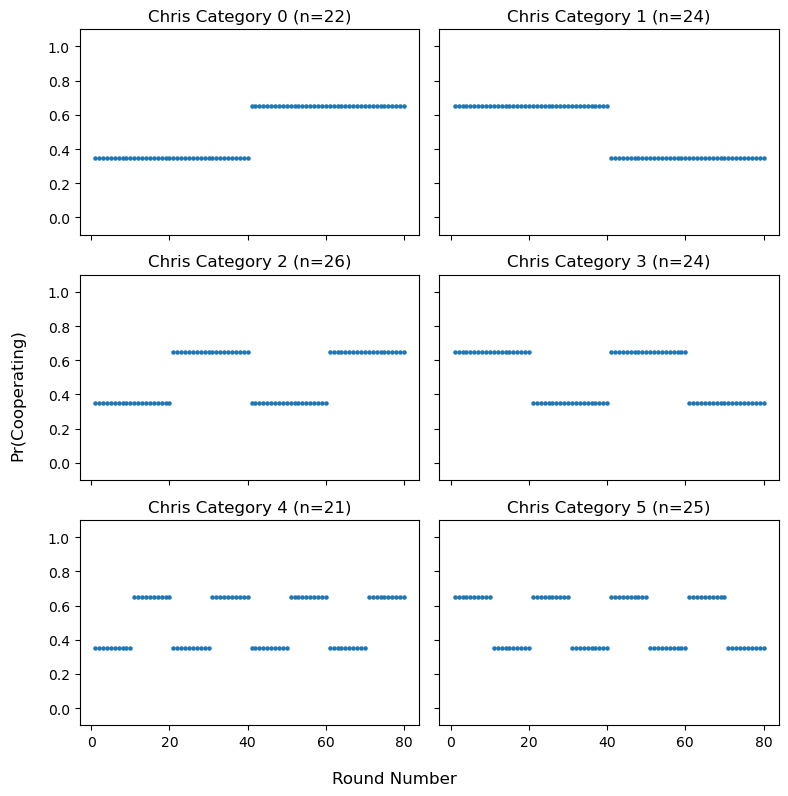

In [47]:
# Visalize chris category
fig, axs = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)
rounds = np.arange(1, 81)
for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        ax.scatter(rounds, chirs_categoty[idx], s=5)
        ax.set_title(f'Chris Category {idx} (n={len(subjects_category[idx])})')
        ax.set_ylim(-0.1, 1.1)
    else:
        ax.axis('off')

fig.supxlabel('Round Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)

plt.tight_layout()
plt.show()